# EDSA - Climate Change Belief Analysis 2022

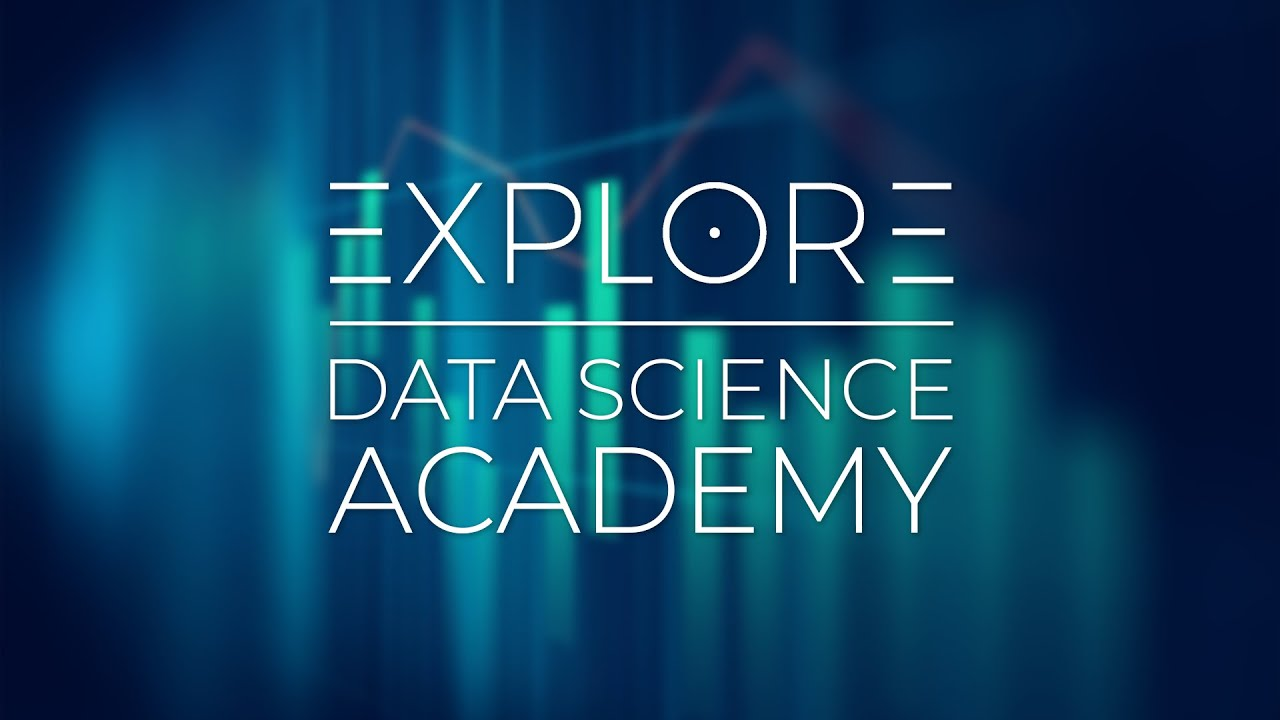

## Running experiment on comet

In [1]:
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="g1JQVB0b78cX75nwigIBpE34r",
    project_name="ac-predict",
    workspace="mainamwangi49",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET WARNING: Failed to check backend version at URL: 'https://www.comet-ml.com/clientlib/isAlive/ver'
COMET ERROR: Run will not be logged 
For more details, please refer to: https://www.comet.ml/docs/python-sdk/warnings-errors/
Traceback (most recent call last):
  File "C:\Users\Hudson\anaconda3\lib\site-packages\urllib3\connection.py", line 159, in _new_conn
    conn = connection.create_connection(
  File "C:\Users\Hudson\anaconda3\lib\site-packages\urllib3\util\connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "C:\Users\Hudson\anaconda3\lib\socket.py", line 918, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above excep


## 1. Importing Packages


In [2]:

# Loading Data
import pandas as pd
import numpy as np
import nltk
import string
import re
import time

# Data Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.utils import resample
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer

# Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

# Model Evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
#from scikitplot.metrics import plot_roc, plot_confusion_matrix

# Explore Data Analysis
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
from matplotlib.pyplot import rcParams

from sklearn.feature_extraction.text import CountVectorizer




In [3]:
#download libraries
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
sns.set_style('whitegrid')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>



## 2. Loading Data


We first load the data and inspect its head.

In [4]:
# Loading the Train data set.
train = pd.read_csv('train.csv')

# Loading the test data set.
test = pd.read_csv('test_with_no_labels.csv')



In [5]:
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [6]:
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928



## 3. Exploratory Data Analysis (EDA)


In this section we perform exploratory data analysis on the data to gain a better understanding of the features and the relationships between them. We will employ both statistical and visualisation methods of EDA.

In [7]:
#create a copy of the origional data
train_copy = train.copy()
test_copy = test.copy()

In [8]:
#check the number of rows and columns in the train data
train_copy.shape

(15819, 3)

In [9]:
#check the number of rows and columns in the test data
test_copy.shape

(10546, 2)

In [10]:
#check for null values in the train data
train_copy.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [11]:
#check for null values in the test data
test_copy.isnull().sum()

message    0
tweetid    0
dtype: int64

### Climate change sentiments distribution
The different classes of sentiments regarding climate change are distributed as follows:

In [12]:
#extract the value counts per sentiment class
count = train_copy.sentiment.value_counts()
#calculate the percentage of each sentiment class
percentage = 100*train_copy.sentiment.value_counts()/len(train_copy.sentiment)
percentage = round(percentage,2)
data = pd.concat([count,percentage],axis =1,)
data.columns = ['Count', 'Percentage']
data

,Count,Percentage
1,8530,53.92
2,3640,23.01
0,2353,14.87
-1,1296,8.19


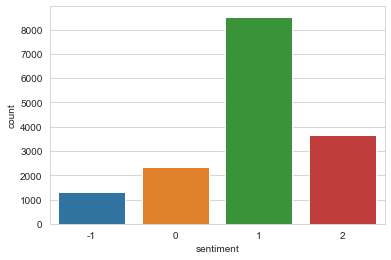

In [13]:
sns.countplot(x='sentiment',data=train_copy,palette='tab10')

From the bar graph we observe that there is an imbalanced distribution of sentiments classes in the training data.

This class imbalance could result in the model classifying most of the tweets into sentiment class 1 since the model gets better at classifying class 1 tweets as the model has more evidence of class 1 tweets. The preprocessing and modeling section of the predict will take this into account.

### Tweets statistics

In [14]:
#brief description of the train data
train_copy.message.describe()

count                                                 15819
unique                                                14229
top       RT @StephenSchlegel: she's thinking about how ...
freq                                                    307
Name: message, dtype: object

In [15]:
#brief description of the test data
test_copy.message.describe()

count                                                 10546
unique                                                 9575
top       RT @StephenSchlegel: she's thinking about how ...
freq                                                    199
Name: message, dtype: object

In [16]:
#description of the train data per sentiment class
train_copy[['sentiment','message']].groupby('sentiment').describe()

message                                                            \
            count unique                                                top   
sentiment                                                                     
-1           1296   1222  RT @realDonaldTrump: The concept of global war...   
 0           2353   2245  RT @ULTRAVlOLENCE: Interviewer: 'What do you t...   
 1           8530   7224  RT @StephenSchlegel: she's thinking about how ...   
 2           3640   3542  RT @business: China tells Trump climate change...   

                
          freq  
sentiment       
-1          22  
 0          20  
 1         307  
 2          12

### Tweets length

Add a length column to the train and test data which shows the number of characters per tweet

In [17]:
train_copy['length'] = train_copy['message'].apply(len)
train_copy.head()

,sentiment,message,tweetid,length
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,140
1,1,It's not like we lack evidence of anthropogeni...,126103,62
2,2,RT @RawStory: Researchers say we have three ye...,698562,140
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,99
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,122


In [18]:
test_copy['length'] = test_copy['message'].apply(len)
test_copy.head()

,message,tweetid,length
0,Europe will now be looking to China to make su...,169760,121
1,Combine this with the polling of staffers re c...,35326,132
2,"The scary, unimpeachable evidence that climate...",224985,139
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,136
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,79


C:\Users\Hudson\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


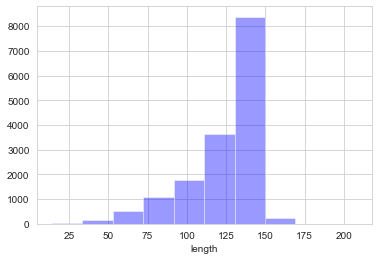

In [19]:
#distribution of tweets length in the train data
sns.distplot(train_copy['length'],bins=10,kde=False,color='blue')

In [20]:
train_copy['length'].describe()

count    15819.000000
mean       123.774132
std         23.332433
min         14.000000
25%        114.000000
50%        133.000000
75%        140.000000
max        208.000000
Name: length, dtype: float64

In [21]:
#print the longest tweet in the train data
train_copy[train_copy['length'] == 208]['message'].iloc[0]

"RT @athakur98: i respect differing opinions but i WILL fight you if you don't believe in climate change bc that's Ã°Å¸â€˜ï†\x8fÃ°Å¸ï†\x8fÂ½ not Ã°Å¸â€˜ï†\x8fÃ°Å¸ï†\x8fÂ½ an Ã°Å¸â€˜ï†\x8fÃ°Å¸ï†\x8fÂ½ opinion Ã°Å¸â€˜ï†\x8fÃ°Å¸ï†\x8fÂ½"

The length of the tweets in the train data lie between 208 characters and 14 characters. The longest tweet contains only a few actual words. This will be taken into consideration in the preprocessing section of the predict to ensure that any noise in the tweets is removed.

C:\Users\Hudson\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


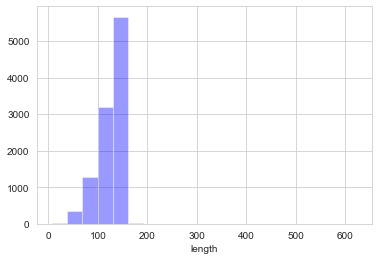

In [22]:
#distribution of tweets length in the test data
sns.distplot(test_copy['length'],bins=20,kde=False,color='blue')

In [23]:
test_copy['length'].describe()

count    10546.000000
mean       123.738764
std         23.752069
min          7.000000
25%        114.000000
50%        132.000000
75%        140.000000
max        623.000000
Name: length, dtype: float64

In [24]:
#print the longest tweet in the train data
test_copy[test_copy['length'] == 623]['message'].iloc[0]

'RT @Hopeniverse: Ã\xa0Â¸Â£Ã\xa0Â¸ÂµÃ\xa0Â¸Â§Ã\xa0Â¸Â´Ã\xa0Â¸Â§Ã\xa0Â¸Â£Ã\xa0Â¸Âª global warming Ã\xa0Â¸â€žÃ\xa0Â¹Ë†Ã\xa0Â¸Â° Ã\xa0Â¹â€šÃ\xa0Â¸â€\x9dÃ\xa0Â¸â„¢Ã\xa0Â¸Â«Ã\xa0Â¸â„¢Ã\xa0Â¹â€°Ã\xa0Â¸Â²Ã\xa0Â¸â€¢Ã\xa0Â¸Â²Ã\xa0Â¸â„¢Ã\xa0Â¹Ë†Ã\xa0Â¸Â²Ã\xa0Â¸Â£Ã\xa0Â¸Â±Ã\xa0Â¸ï†\x81Ã\xa0Â¸Â«Ã\xa0Â¸Â¥Ã\xa0Â¸Â\xadÃ\xa0Â¸ï†\x81Ã\xa0Â¹Æ’Ã\xa0Â¸Â«Ã\xa0Â¹â€°Ã\xa0Â¸â€¹Ã\xa0Â¸Â·Ã\xa0Â¹â€°Ã\xa0Â¸Â\xadÃ\xa0Â¸Â¡Ã\xa0Â¸Â² Ã\xa0Â¹â‚¬Ã\xa0Â¸Â«Ã\xa0Â¸Â¡Ã\xa0Â¸Â·Ã\xa0Â¸Â\xadÃ\xa0Â¸â„¢Ã\xa0Â¹â‚¬Ã\xa0Â¸â€žÃ\xa0Â¸ÂµÃ\xa0Â¹â€°Ã\xa0Â¸Â¢Ã\xa0Â¸Â§Ã\xa0Â¹â€šÃ\xa0Â¸Â\xadÃ\xa0Â¸Â£Ã\xa0Â¸Â´Ã\xa0Â¹â€šÃ\xa0Â¸Â\xadÃ\xa0Â¹â€°Ã\xa0Â¹ï†\x81Ã\xa0Â¸Â¥Ã\xa0Â¹â€°Ã\xa0Â¸Â§Ã\xa0Â¹ï†\x81Ã\xa0Â¸â€ºÃ\xa0Â¸Â£Ã\xa0Â¸â€¡Ã\xa0Â¸Å¸Ã\xa0Â¸Â±Ã\xa0Â¸â„¢Ã\xa0Â¹â€žÃ\xa0Â¸â€ºÃ\xa0Â¸â€\x9dÃ\xa0Â¹â€°Ã\xa0Â¸Â§Ã\xa0Â¸Â¢Ã\xa0Â¹Æ’Ã\xa0Â¸â„¢Ã\xa0Â¹â‚¬Ã\xa0Â¸Â§Ã\xa0Â¸Â¥Ã\xa0Â¸Â²Ã\xa0Â¹â‚¬Ã\xa0Â¸â€\x9dÃ\xa0Â¸ÂµÃ\xa0Â¸Â¢Ã\xa0Â¸Â§Ã\xa0Â¸ï†\x81Ã\xa0Â¸Â±Ã\xa0Â¸â„¢ https://t.co/XqÃ¢â‚¬Â¦'

Similar to the train data, the longest tweet in the test data contains only a few actual words. This will be taken into consideration in the preprocessing section of the predict to ensure that any noise in the tweets is removed.

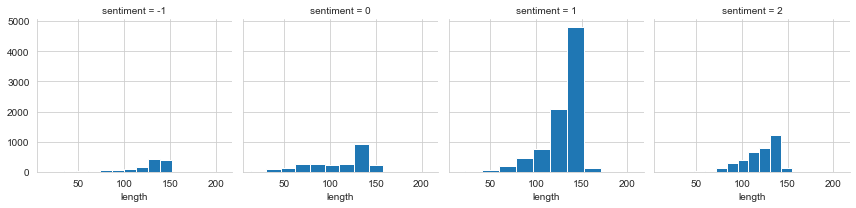

In [25]:
#length of tweets per sentiment class in the train data
_ = sns.FacetGrid(train_copy,col='sentiment')
_.map(plt.hist,'length')

Generally, we observe that sentiment 1 tweets are longer than any other sentiment classes. Sentiment -1 seems to have the shortest tweets length.

### Major topics surrounding the climate change tweets
We undertake an analysis of the major topics in the tweets data by extracting the most frequently used words and hashtags. This will be essential in illustrating the sentiments attached to climate change.

Text(0.5, 1.0, 'Train_data : 20 Most Frequently Occuring Words')

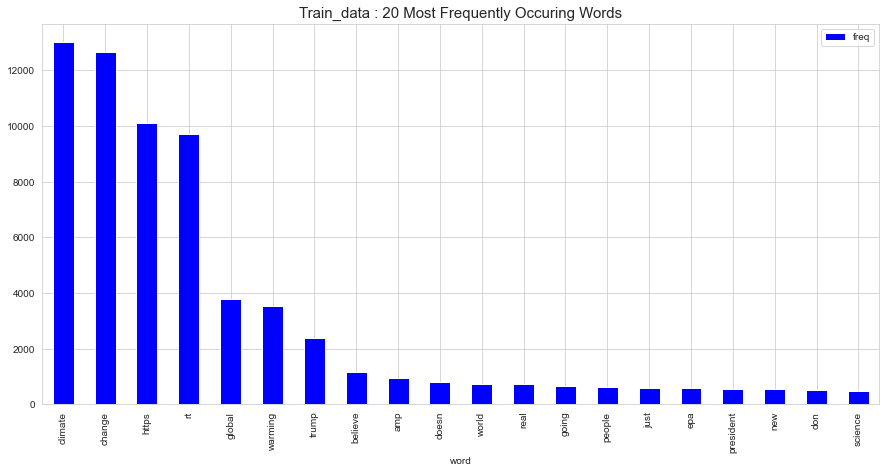

In [26]:

#convert the test to numerical values 
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train_copy.message)

sum_words = words.sum(axis=0)
#create a frequency of most occuring words
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
#create a dataframe of the words and frequency 
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Train_data : 20 Most Frequently Occuring Words",size=15)

Text(0.5, 1.0, 'Test_data : 20 Most Frequently Occuring Words')

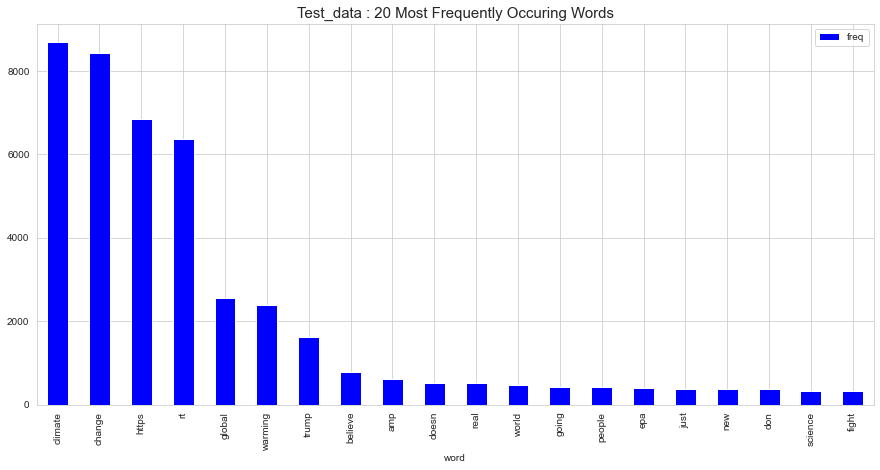

In [27]:

#convert the test to numerical values 
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(test_copy.message)

sum_words = words.sum(axis=0)
#create a frequency of most occuring words
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
#create a dataframe of the words and frequency 
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Test_data : 20 Most Frequently Occuring Words",size=15)

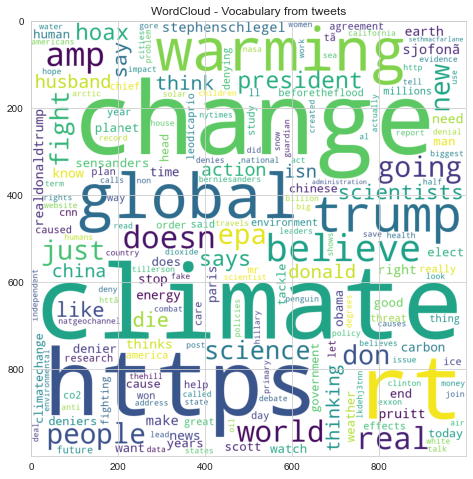

In [28]:
#creating a word cloud from the data
wordcloud = WordCloud(background_color = 'white', 
                      width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(8,8))
plt.title("WordCloud - Vocabulary from tweets")
plt.imshow(wordcloud)

### Hashtags used per sentiment class
The main function of a hashtag is to categorize tweets based on a keyword or a topic associated with the hashtag used. Generally, people use hashtags before a relevant phrase or keyword.

The hashtags used in the climate change tweets highlight the people's interest in the climate change topic.

We analyse the hashtags used within each sentiment class.

In [29]:
# collecting the hashtags

def hashtag_extract(x):
    """
    The function extract the hashtags
    from the messages column
    """
    hashtags = []    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

In [30]:
# extracting hashtags from train tweets
HT_train_neg = hashtag_extract(train_copy['message'][train_copy['sentiment'] == -1])
HT_train0 = hashtag_extract(train_copy['message'][train_copy['sentiment'] == 0])
HT_train1 = hashtag_extract(train_copy['message'][train_copy['sentiment'] == 1])
HT_train2 = hashtag_extract(train_copy['message'][train_copy['sentiment'] == 2])


# unnesting list
HT_train_neg = sum(HT_train_neg,[])
HT_train0 = sum(HT_train0,[])
HT_train1 = sum(HT_train1,[])
HT_train2 = sum(HT_train2,[])

#### Top 10 hashtags in Sentiment  -1 

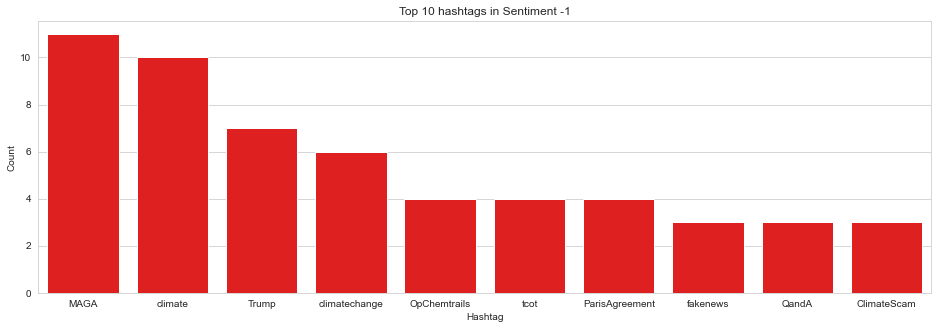

In [31]:
#creating a frequency distribution of the hashtags
a = nltk.FreqDist(HT_train_neg)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
plt.title('Top 10 hashtags in Sentiment -1')
ax = sns.barplot(data=d, x= "Hashtag", y = "Count", color ='red')
ax.set(ylabel = 'Count')
plt.show()

The #MAGA(Make America Great Again) is the top hashtag used in sentiment -1 tweets with the second being #climate. Other interesting hashtags that appear in the top 10 hashtags are #fakenews and #ClimateScam which insinuate that some of the people who were tweeting believe that climate change is simply fake news or a scam. 

#### Top 10 hashtags in Sentiment 0

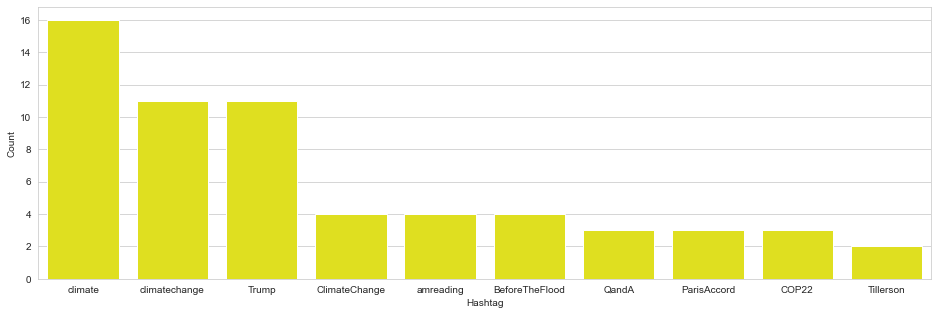

In [32]:
#creating a frequency distribution of the hashtags
a = nltk.FreqDist(HT_train0)
c = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags 
c = c.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=c, x= "Hashtag", y = "Count",color ='yellow')
ax.set(ylabel = 'Count')
plt.show()

The hashtag that is used the most in sentiment 0 tweets is #climate followed by #climatechange. An interesting hashtag used in this class is #BeforeTheFlood which is a movie that depicts the impacts of climate change on the Earth. This insunuates that sentiments within class 0 are open conversations surrounding climate change including people asking questions about climate change.

#### Top 10 hashtags in Sentiment 1

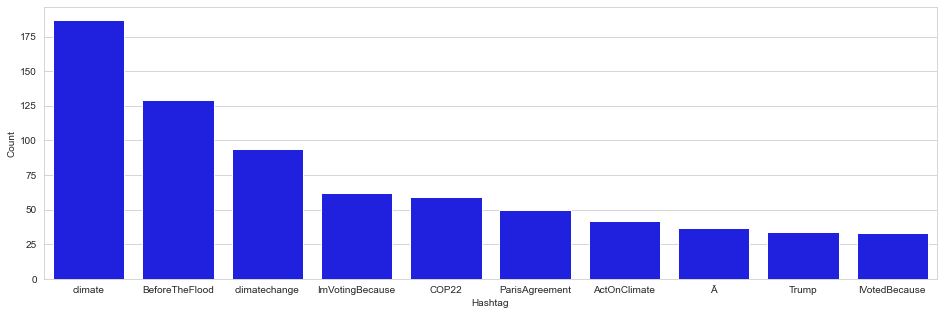

In [33]:
#creating a frequency distribution of the hashtags
a = nltk.FreqDist(HT_train1)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count",color ='blue')
ax.set(ylabel = 'Count')
plt.show()

An interesting hashtag in sentiment 1 tweets is #ActOnClimate which is associated with discussions on ways to combat climate change.

#### Top 10 hashtags in Sentiment 2

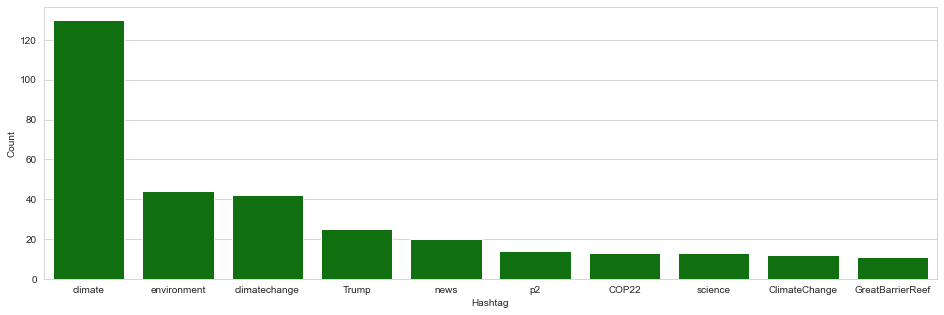

In [34]:
#creating a frequency distribution of the hashtags
a = nltk.FreqDist(HT_train2)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count",color='green')
ax.set(ylabel = 'Count')
plt.show()

The opinions in sentiment 2 mainly focus on the climate which is evident in the high hashtag count of the word #climate and #enviroment. This insinuates that the class is mainly focused on informing people about climate change and its effect on the enviroment.

### Key findings from the EDA

* There exists a class imbalance within the different classes of sentiments in the tweets data. This will be addressed in the preprocessing and model training section.

* Frome the analysis of the hashtags we can insinuate that tweets in sentiment -1 do not believe that climate change exists, sentiment 0 are neutral, sentiment 1 believe in climate change, while sentiment 2 believe and inform people about climate change.



## Data Preprocessing

This section deals with the getting rid of data which does not add any value to the sentiment classification. This consists of punctuation, images, videos, URLs, usernames, emojis which do not contribute to the polarity of the tweet (whether positive or negative).

**The following techniques will be employed to clean our data**

- Removing noise
- Removing stop Words
- Tokenisation
- Lemmatisation 
- Normalization

## Dealing with Class Imbalance

In training the classification model, it is preferable for all classes to have a relatively even split of observations. To achieve this in our data we employ the resampling technique.

### Resampling

Resampling methods involve modifying the number of observations in each class as follows:

- **Downsampling** - taking a random subset of the majority class small enough to match the number of observations in the minority class.

- **Upsampling** - taking repeated random samples from the minority class until we have as many observations as the  majority class. This grows the size of the minority class by effectively duplicating observations at random.


We resample the data as follows:

In [35]:
def resambling(df):
    """
        The functions takes in dataframe and resample the classses base on class size.
        The class size is a average of the datasets among the classes.
        This function resamples by downsampling classes with observations greater than the class size and
        upsampling the classes with observations smaller than the class size.
    """
    df = df.copy()
    class_2 = df[df['sentiment'] == 2]  
    class_1 = df[df['sentiment'] == 1]  
    class_0 = df[df['sentiment'] == 0]  
    class_n1 = df[df['sentiment'] == -1] 
    class_size = 4265
    # Downsampling class_1 the PRO class
    rclass_1 = resample(class_1, replace=False, n_samples=class_size, random_state=42)
    #upsampling class 2 the NEWS class
    rclass_2 = resample(class_2, replace=True, n_samples=class_size, random_state=42)
    #upsampling class 0 NUETRAL class
    rclass_0 = resample(class_0, replace=True, n_samples=class_size, random_state=42)
    #upsampling class -1 the ANTI class
    rclass_n1 = resample(class_n1, replace=True, n_samples=class_size, random_state=42)
    sampled_df = pd.concat([rclass_2, rclass_1, rclass_0, rclass_n1])
    
    return sampled_df

In [36]:
# Resammpled train data
Resampled_train_df = resambling(train)

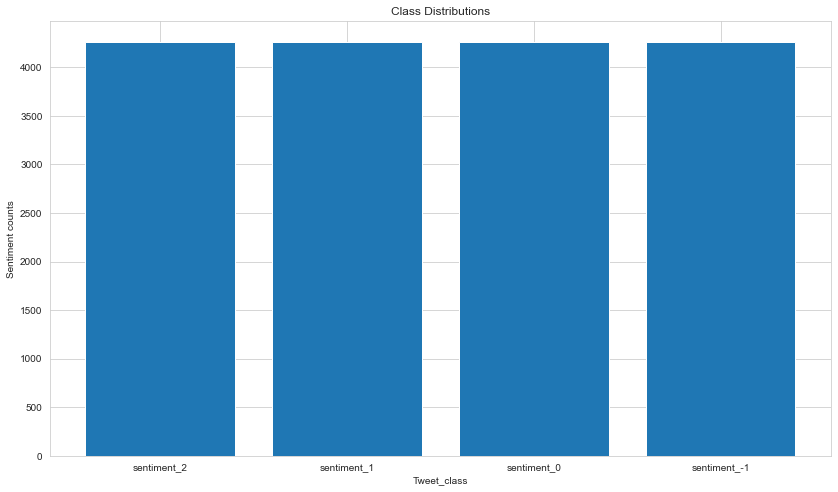

In [37]:
sentiment_2 = Resampled_train_df[Resampled_train_df.sentiment == 2].shape[0]
sentiment_1 = Resampled_train_df[Resampled_train_df.sentiment == 1].shape[0]
sentiment_0 = Resampled_train_df[Resampled_train_df.sentiment == 0].shape[0]
sentiment_ = Resampled_train_df[Resampled_train_df.sentiment == -1].shape[0]
#visualising
plt.figure(1,figsize=(14,8))
plt.bar(["sentiment_2", "sentiment_1", "sentiment_0" , "sentiment_-1"],[sentiment_2, sentiment_1, sentiment_0 , sentiment_])
plt.xlabel('Tweet_class')
plt.ylabel('Sentiment counts')
plt.title('Class Distributions')
plt.show()

### Text Cleaning


In [38]:
# Creating copy of the resampled train data
train_copy = Resampled_train_df.copy()


#### Removing Noise

We will remove the noise in our data as follows:
- Convert letters to lowercases
- Remove URL links 
- Remove hashtag/numbers
- Remove punctuation

In [39]:
def cleaner(tweet):
    """
    this function takes in a dataframe and does the following:
    -convert letters to lowercase
    -remove URL links
    -remove # from hashtags
    -remove numbers
    -remove punctuation
 
    """
    tweet = tweet.lower()
    to_del = [
        r"@[\w]*",  # strip account mentions
        r"http(s?):\/\/.*\/\w*",  # strip URLs
        r"#\w*",  # strip hashtags
        r"\d+",  # delete numeric values
        r"U+FFFD",  # remove the "character note present" diamond
    ]
    for key in to_del:
        tweet = re.sub(key, "", tweet)
    
    # strip punctuation and special characters
    tweet = re.sub(r"[,.;':@#?!\&/$]+\ *", " ", tweet)
    # strip excess white-space
    tweet = re.sub(r"\s\s+", " ", tweet)
    
    return tweet.lstrip(" ")

In [40]:
train_copy['message'] = train_copy['message'].apply(cleaner)
train_copy.head()

,sentiment,message,tweetid
13776,2,rt europe faces droughts floods storms as chan...,849649
15247,2,el nino on a warming planet may have sparked t...,610545
3533,2,rt trump says keeping an open mind on climate ...,625516
5570,2,rt sierra club calls for investigation of epa ...,86301
4824,2,tackling climate change will boost economic gr...,291460


#### Removing Stop Words

Stop words are common words like "if", "but", "we", "he", "she" and "she" which can be removed without changing the semantics of any text, and doing so often (but not always) improves the performance of a model. Removing these stop words becomes much more useful when we use longer sequences of words as model features.

In [41]:
stop_word = stopwords.words('english')
train_copy['message'] = train_copy['message'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_word)]))
train_copy.head()

,sentiment,message,tweetid
13776,2,rt europe faces droughts floods storms change ...,849649
15247,2,el nino warming planet may sparked zika epidem...,610545
3533,2,rt trump says keeping open mind climate change...,625516
5570,2,rt sierra club calls investigation epa head cl...,86301
4824,2,tackling climate change boost economic growth ...,291460


#### Tokenisation

Tokenisation is the process of breaking the raw text into small chunks of words, sentences called tokens. These tokens help in interpreting the meaning of the text by analyzing the sequence of the words.

In [42]:
tokeniser = TreebankWordTokenizer()
train_copy['tokens'] = train_copy['message'].apply(tokeniser.tokenize)
train_copy.head()

,sentiment,message,tweetid,tokens
13776,2,rt europe faces droughts floods storms change ...,849649,"[rt, europe, faces, droughts, floods, storms, ..."
15247,2,el nino warming planet may sparked zika epidem...,610545,"[el, nino, warming, planet, may, sparked, zika..."
3533,2,rt trump says keeping open mind climate change...,625516,"[rt, trump, says, keeping, open, mind, climate..."
5570,2,rt sierra club calls investigation epa head cl...,86301,"[rt, sierra, club, calls, investigation, epa, ..."
4824,2,tackling climate change boost economic growth ...,291460,"[tackling, climate, change, boost, economic, g..."


#### Lemmatisation

Lemmatizing is the process of grouping words of similar meaning together. 

In [43]:
def lemmas(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]

In [44]:
lemmatizer = WordNetLemmatizer()
train_copy['lemma'] = train_copy['tokens'].apply(lemmas, args=(lemmatizer, ))
train_copy.head()

,sentiment,message,tweetid,tokens,lemma
13776,2,rt europe faces droughts floods storms change ...,849649,"[rt, europe, faces, droughts, floods, storms, ...","[rt, europe, face, drought, flood, storm, chan..."
15247,2,el nino warming planet may sparked zika epidem...,610545,"[el, nino, warming, planet, may, sparked, zika...","[el, nino, warming, planet, may, sparked, zika..."
3533,2,rt trump says keeping open mind climate change...,625516,"[rt, trump, says, keeping, open, mind, climate...","[rt, trump, say, keeping, open, mind, climate,..."
5570,2,rt sierra club calls investigation epa head cl...,86301,"[rt, sierra, club, calls, investigation, epa, ...","[rt, sierra, club, call, investigation, epa, h..."
4824,2,tackling climate change boost economic growth ...,291460,"[tackling, climate, change, boost, economic, g...","[tackling, climate, change, boost, economic, g..."


### Text Feature Extraction

In [45]:
#split the features from the labels
y = train_copy['sentiment']
X = train_copy['message']

#### Data transformation with TfidfVectorizer

TFIDF assigns word frequency scores, these scores try to highlight words of greater interest. The TFIDFVectorizer will tokenize the documents, learn the vocabulary and inverse document frequency weightings, and allow you to encode new documents.

In [46]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, stop_words="english")
X_vectorized = vectorizer.fit_transform(X)

### Model Building

We will fit several machine learning models namely logistic classifier,  K nearest neighbors classifier, decision tree classifier, random forest classifier, support vector machine classifier, linear SVC, and the multinomial naive bayes. We will then evaluate the models to find out which performs the best.

In [47]:
#split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_vectorized,y,test_size=.3,shuffle=True, stratify=y, random_state=11)

#### Logistic Regression Classifier

The logistic regression classifier is a supervised machine learning classification algorithm that is used to predict the probability of a categorical dependent variable. 

In [48]:
lr = LogisticRegression(multi_class='ovr')
lr.fit(X_train, y_train)

LogisticRegression(multi_class='ovr')

#### K nearest neighbors

The K-nearest neighbors (KNN) is a supervised machine learning algorithm which works by finding the distances between a query and all the examples in the data, selecting the specified number examples (K) closest to the query, then votes for the most frequent label.

In [49]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

#### Decision Tree Classifier

Decision tree machine learning algorithm works by partitioning data it into different sections based on questions asked of independent variables in the data. Training data is placed at the root node and is then partitioned into smaller subsets which form the 'branches' of the tree.

In [50]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

#### Random Forest Classifier

The random forest classifier is a supervised learning algorithm. Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. 

In [51]:
rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### Support Vector Machine Classifier

The Support Vector Machine Classifier is a discriminative classifier formally defined by a separating hyperplane. When labelled training data is passed to the model, also known as supervised learning, the algorithm outputs an optimal hyperplane which categorizes new data.

In [52]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

SVC(kernel='linear')

#### Linear SVC

The objective of a Linear Support Vector Classifier is to return a "best fit" hyperplane that categorises the data. It is similar to SVC with the kernel parameter set to ’linear’, but it is implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and can scale better to large numbers of samples.

In [53]:
lsvm = LinearSVC()
lsvm.fit(X_train, y_train)

LinearSVC()

#### Multinomial Naive Bayes

The Multinomial Naive Bayes model estimates the conditional probability of a particular feature given a class and uses a multinomial distribution for each of the features. The model assumes that each feature makes an independent and equal contribution to the outcome.

In [54]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

### Model Evaluation

The models will be evaluated using the test data

In [55]:
#classification report logistic regression
y_pred_lr = lr.predict(X_test)
lr_f1 = round(f1_score(y_test, y_pred_lr, average='weighted'),2)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

          -1       0.91      0.91      0.91      1280
           0       0.84      0.84      0.84      1280
           1       0.79      0.70      0.74      1279
           2       0.79      0.88      0.84      1279

    accuracy                           0.83      5118
   macro avg       0.83      0.83      0.83      5118
weighted avg       0.83      0.83      0.83      5118



In [56]:
#classification report KNN
y_pred_knn = knn.predict(X_test)
knn_f1 = round(f1_score(y_test, y_pred_knn, average='weighted'),2)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

          -1       0.96      0.92      0.94      1280
           0       0.97      0.79      0.87      1280
           1       0.64      0.93      0.76      1279
           2       0.95      0.74      0.83      1279

    accuracy                           0.84      5118
   macro avg       0.88      0.84      0.85      5118
weighted avg       0.88      0.84      0.85      5118



In [57]:
#classification report decision tree
y_pred_dt = dt.predict(X_test)
dt_f1 = round(f1_score(y_test, y_pred_dt, average='weighted'),2)
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

          -1       0.89      0.93      0.91      1280
           0       0.83      0.87      0.85      1280
           1       0.75      0.68      0.71      1279
           2       0.80      0.80      0.80      1279

    accuracy                           0.82      5118
   macro avg       0.82      0.82      0.82      5118
weighted avg       0.82      0.82      0.82      5118



In [58]:
#classification report random forest
y_pred_rf = rf.predict(X_test)
rf_f1 = round(f1_score(y_test, y_pred_rf, average='weighted'),2)
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

          -1       0.97      0.94      0.95      1280
           0       0.86      0.88      0.87      1280
           1       0.78      0.78      0.78      1279
           2       0.84      0.85      0.85      1279

    accuracy                           0.86      5118
   macro avg       0.86      0.86      0.86      5118
weighted avg       0.86      0.86      0.86      5118



In [59]:
#classification report svm
y_pred_svm = svm.predict(X_test)
svm_f1 = round(f1_score(y_test, y_pred_svm, average='weighted'),2)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

          -1       0.93      0.94      0.94      1280
           0       0.87      0.86      0.86      1280
           1       0.79      0.76      0.78      1279
           2       0.85      0.88      0.87      1279

    accuracy                           0.86      5118
   macro avg       0.86      0.86      0.86      5118
weighted avg       0.86      0.86      0.86      5118



In [60]:
#classification report lsvm
y_pred_lsvm = lsvm.predict(X_test)
lsvm_f1 = round(f1_score(y_test, y_pred_lsvm, average='weighted'),2)
print(classification_report(y_test, y_pred_lsvm))

              precision    recall  f1-score   support

          -1       0.92      0.95      0.93      1280
           0       0.86      0.87      0.86      1280
           1       0.81      0.74      0.77      1279
           2       0.84      0.88      0.86      1279

    accuracy                           0.86      5118
   macro avg       0.86      0.86      0.86      5118
weighted avg       0.86      0.86      0.86      5118



In [61]:
#classification report mnb
y_pred_mnb = mnb.predict(X_test)
mnb_f1 = round(f1_score(y_test, y_pred_mnb, average='weighted'),2)
print(classification_report(y_test, y_pred_mnb))

              precision    recall  f1-score   support

          -1       0.89      0.90      0.90      1280
           0       0.90      0.77      0.83      1280
           1       0.70      0.78      0.74      1279
           2       0.83      0.86      0.84      1279

    accuracy                           0.83      5118
   macro avg       0.83      0.83      0.83      5118
weighted avg       0.83      0.83      0.83      5118



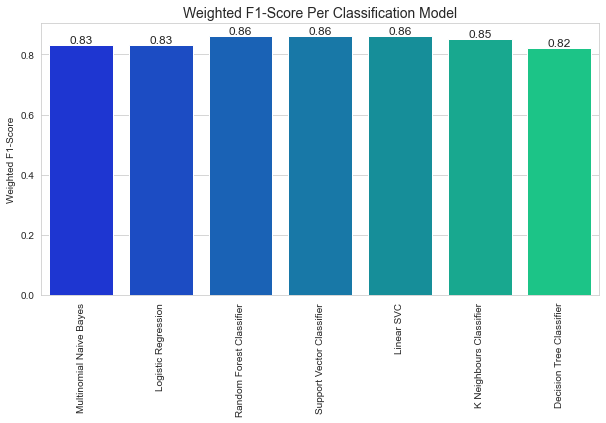

In [62]:
# Compare Weighted F1-Scores Between Models
fig,axis = plt.subplots(figsize=(10, 5))
rmse_x = ['Multinomial Naive Bayes','Logistic Regression','Random Forest Classifier',
          'Support Vector Classifier','Linear SVC','K Neighbours Classifier','Decision Tree Classifier']
rmse_y = [mnb_f1,lr_f1,rf_f1,svm_f1,lsvm_f1,knn_f1,dt_f1]
ax = sns.barplot(x=rmse_x, y=rmse_y,palette='winter')
plt.title('Weighted F1-Score Per Classification Model',fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('Weighted F1-Score')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height(), 
            round(p.get_height(),2), fontsize=12, ha="center", va='bottom')
    
plt.show()

The top three classifiers are random forest, support vector 

### Model Tuning

In [63]:
# Ignore warnings
import warnings
warnings.simplefilter(action='ignore')

# Install Prerequisites
# import sys
# import nltk
# !{sys.executable} -m pip install bs4 lxml wordcloud scikit-learn scikit-plot
# nltk.download('vader_lexicon')

# Exploratory Data Analysis
import re
import ast
import time
import nltk
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
#from textblob import TextBlob
import matplotlib.pyplot as plt
#from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer

# Data Preprocessing
import string
from bs4 import BeautifulSoup
from collections import Counter
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.utils import resample
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Classification Models
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Performance Evaluation
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
#from scikitplot.metrics import plot_roc, plot_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

# Display
%matplotlib inline
sns.set(font_scale=1)
sns.set_style("white")

In [64]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test_with_no_labels.csv')
#train_data = pd.read_csv('/train.csv')
#test_data = pd.read_csv('/test.csv')
df_train = train_data.copy() #For EDA on raw data
df_test = test_data.copy()

In [65]:
# Final Cleaning
def sentiment_changer(df):
    """
    Change key words to reflect the general sentiment associated with it.
    """
    df['message'] = df['message'].apply(lambda x: x.replace('global', 'negative'))
    df['message'] = df['message'].apply(lambda x: x.replace('climate', 'positive'))
    df['message'] = df['message'].apply(lambda x: x.replace('MAGA', 'negative'))
    return df['message']

train_data['message'] = sentiment_changer(train_data)
test_data['message'] = sentiment_changer(test_data)

def clean(df):
    """
    Apply data cleaning steps to raw data.
    """
    df['token'] = df['message'].apply(TweetTokenizer().tokenize) ## first we tokenize
    df['punc'] = df['token'].apply(lambda x : [i for i in x if i not in string.punctuation])## remove punctuations
    df['dig'] = df['punc'].apply(lambda x: [i for i in x if i not in list(string.digits)]) ## remove digits
    df['final'] = df['dig'].apply(lambda x: [i for i in x if len(i) > 1]) ## remove all words with only 1 character
    return df['final']

train_data['final'] = clean(train_data)
test_data['final'] = clean(test_data)

In [66]:
import nltk
nltk.download('wordnet')

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [67]:
def get_part_of_speech(word):
    """
    Find part of speech of word if part of speech is either noun, verb, adjective etc and add it to a list.
    """
    probable_part_of_speech = wordnet.synsets(word) ## finding word that is most similar (synonyms) for semantic reasoning
    pos_counts = Counter() ## instantiating our counter class
    pos_counts["n"] = len([i for i in probable_part_of_speech if i.pos()=="n"])
    pos_counts["v"] = len([i for i in probable_part_of_speech if i.pos()=="v"])
    pos_counts["a"] = len([i for i in probable_part_of_speech if i.pos()=="a"])
    pos_counts["r"] = len([i for i in probable_part_of_speech if i.pos()=="r"])
    most_likely_part_of_speech = pos_counts.most_common(1)[0][0] ## will extract the most likely part of speech from the list
    return most_likely_part_of_speech

normalizer = WordNetLemmatizer()

train_data['final'] = train_data['final'].apply(lambda x: [normalizer.lemmatize(token, get_part_of_speech(token)) for token in x])
test_data['final'] = test_data['final'].apply(lambda x: [normalizer.lemmatize(token, get_part_of_speech(token)) for token in x])

In [68]:
X = train_data['final']
y = train_data['sentiment']
X_test = test_data['final']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state = 42)

In [69]:
X_train = list(X_train.apply(' '.join))
X_val = list(X_val.apply(' '.join))

vectorizer = TfidfVectorizer(sublinear_tf=True, smooth_idf = True, max_df = 0.3, min_df = 5, ngram_range = (1, 2))
vectorizer.fit(X_train)

# vect_save_path = "TfidfVectorizer.pkl"
# with open(vect_save_path,'wb') as file:
#     pickle.dump(vectorizer,file)

X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)

In [71]:
modelstart = time.time()
svc = SVC(gamma = 0.8, C = 10, random_state=42)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_val)
svc_f1 = round(f1_score(y_val, y_pred, average='weighted'),2)
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))
report = classification_report(y_val, y_pred, output_dict=True)
results = pd.DataFrame(report).transpose()
results

Accuracy 0.7857142857142857
Model Runtime: 134.19 seconds


,precision,recall,f1-score,support
-1,0.771084,0.507937,0.612440,126.000000
0,0.623377,0.428571,0.507937,224.000000
1,0.796860,0.907263,0.848485,895.000000
2,0.831288,0.804154,0.817496,337.000000
accuracy,0.785714,0.785714,0.785714,0.785714
macro avg,0.755652,0.661981,0.696589,1582.000000
weighted avg,0.777577,0.785714,0.774864,1582.000000


In [72]:
modelstart = time.time() 
linsvc = LinearSVC()
linsvc.fit(X_train, y_train)
y_pred = linsvc.predict(X_val)
linsvc_f1 = round(f1_score(y_val, y_pred, average='weighted'),2)
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))
report = classification_report(y_val, y_pred, output_dict=True)
results = pd.DataFrame(report).transpose()
results

Accuracy 0.7579013906447535
Model Runtime: 0.38 seconds


,precision,recall,f1-score,support
-1,0.659341,0.476190,0.552995,126.000000
0,0.566474,0.437500,0.493703,224.000000
1,0.801031,0.868156,0.833244,895.000000
2,0.758621,0.783383,0.770803,337.000000
accuracy,0.757901,0.757901,0.757901,0.757901
macro avg,0.696367,0.641307,0.662686,1582.000000
weighted avg,0.747500,0.757901,0.749545,1582.000000


In [73]:
LinearSVC().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [74]:
param_grid = {'C': [100],#[0.1,1,10,100,1000]
              'max_iter': [10], #[10,100]
              'multi_class' : ['ovr'], #['crammer_singer', 'ovr']
              'random_state': [42]} 
grid_LSVC = GridSearchCV(LinearSVC(), param_grid, scoring='f1_weighted', cv=5, n_jobs=-1)
grid_LSVC.fit(X_train, y_train)
y_pred = grid_LSVC.predict(X_val)
print(grid_LSVC.best_params_)
print('accuracy %s' % accuracy_score(y_pred, y_val))
print(classification_report(y_val, y_pred))

{'C': 100, 'max_iter': 10, 'multi_class': 'ovr', 'random_state': 42}
accuracy 0.7370417193426043
              precision    recall  f1-score   support

          -1       0.65      0.49      0.56       126
           0       0.56      0.44      0.49       224
           1       0.80      0.82      0.81       895
           2       0.69      0.80      0.74       337

    accuracy                           0.74      1582
   macro avg       0.67      0.64      0.65      1582
weighted avg       0.73      0.74      0.73      1582



In [75]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [76]:
param_grid = {'C': [10],#[0.1,1,10,100,1000]
              'gamma': [0.8], #[0.8,1]
              'kernel': ['rbf'], #['linear','rbf']
              'random_state': [42]} 
grid_SVC = GridSearchCV(SVC(), param_grid, scoring='f1_weighted', cv=5, n_jobs=-1)
grid_SVC.fit(X_train, y_train)
y_pred = grid_SVC.predict(X_val)
print(grid_SVC.best_params_)
print('accuracy %s' % accuracy_score(y_pred, y_val))
print(classification_report(y_val, y_pred))

{'C': 10, 'gamma': 0.8, 'kernel': 'rbf', 'random_state': 42}
accuracy 0.7857142857142857
              precision    recall  f1-score   support

          -1       0.77      0.51      0.61       126
           0       0.62      0.43      0.51       224
           1       0.80      0.91      0.85       895
           2       0.83      0.80      0.82       337

    accuracy                           0.79      1582
   macro avg       0.76      0.66      0.70      1582
weighted avg       0.78      0.79      0.77      1582



In [77]:
# Make prediction on test data
X = train_data['final']
y = train_data['sentiment']
X_test = test_data['final']

X = list(X.apply(' '.join))
X_test = list(X_test.apply(' '.join))

vectorizer = TfidfVectorizer(sublinear_tf=True, smooth_idf = True, max_df = 0.3, min_df = 5, ngram_range = (1, 2))
vectorizer.fit(X)

X = vectorizer.transform(X)
X_test = vectorizer.transform(X_test)

svc = SVC(gamma=0.8, C=10, random_state=42)
svc.fit(X, y)
y_test = svc.predict(X_test)

In [78]:
# Create Kaggle Submission File
results = pd.DataFrame({"tweetid":test_data['tweetid'],"sentiment": y_test})
results.to_csv("submission.csv", index=False)

In [70]:
#Predictions on the test data using svc
testx = test_copy['message']
test_vect = vectorizer.transform(testx)
svc_pred_t = svc.predict(test_vect)

NameError: name 'svc' is not defined

In [ ]:
test['sentiment'] = svc_pred_t
test.head()

In [ ]:
#submission
test[['tweetid','sentiment']].to_csv('testsubmission.csv', index=False)

In [ ]:
experiment.end()